## Import & Setup

Note, if you are getting errors like this:
```
...
from .extension import *
  File ".../isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'
```

Go into `isaacsim/extsUser/go4robo/go4robo_python/__init__.py` and comment out the following line:
```
from .extension import *
```

!! You need to uncomment this line if you plan to run the Isaac Sim extension !!

In [78]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
39622.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
39627.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [20]:
run_id = "20250502_235742"

## Get the generated designs from csv

In [21]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_Robot_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)
df

id          Name  Cost  Perception Entropy  Generation  s0_type  \
0          0  Prior Design   1.0            9.801217           0        1   
1          1      Design 1   1.0           16.749238           1        1   
2          2      Design 2   1.0           10.575028           1        1   
3          3      Design 3   2.0           17.102970           1        1   
4          4      Design 4   2.0            6.881613           1        1   
...      ...           ...   ...                 ...         ...      ...   
34926  34926  Design 34926   1.0            1.644573         499        1   
34927  34927  Design 34927   1.0            1.644573         499        1   
34928  34928  Design 34928   1.0            1.644573         499        1   
34929  34929  Design 34929   1.0            1.644573         499        1   
34930  34930  Design 34930   1.0            1.644573         499        1   

           s0_x      s0_y      s0_z         s0_qw  ...  s3_qy  s3_qz  s4_type  \
0      0.000000  0.000000  0.500000  6.123234e-17  ...    0.0    0.0        0   
1      0.770239  0.731729  0.259698  3.050308e-03  ...    0.0    0.0        0   
2      0.636604  0.993913  0.546071  7.969488e-02  ...    0.0    0.0        0   
3      0.441904  0.581577  0.989752  6.234114e-01  ...    0.0    0.0        0   
4      0.843840  0.381016  0.749858 -3.572056e-01  ...    0.0    0.0        0   
...         ...       ...       ...           ...  ...    ...    ...      ...   
34926  0.998752  0.415708  0.962179  2.251792e-01  ...    0.0    0.0        0   
34927  0.998752  0.415708  0.962179  2.251793e-01  ...    0.0    0.0        0   
34928  0.998752  0.415708  0.962179  2.251793e-01  ...    0.0    0.0        0   
34929  0.998752  0.415708  0.962179  2.251792e-01  ...    0.0    0.0        0   
34930  0.998752  0.415708  0.962179  2.251793e-01  ...    0.0    0.0        0   

       s4_x  s4_y  s4_z  s4_qw  s4_qx  s4_qy  s4_qz  
0       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
1       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
2       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
3       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
4       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
...     ...   ...   ...    ...    ...    ...    ...  
34926   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34927   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34928   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34929   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34930   0.0   0.0   0.0    0.0    0.0    0.0    0.0  

[34931 rows x 45 columns]

## Plot the tradespace

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [22]:
plot_tradespace(df)

Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.


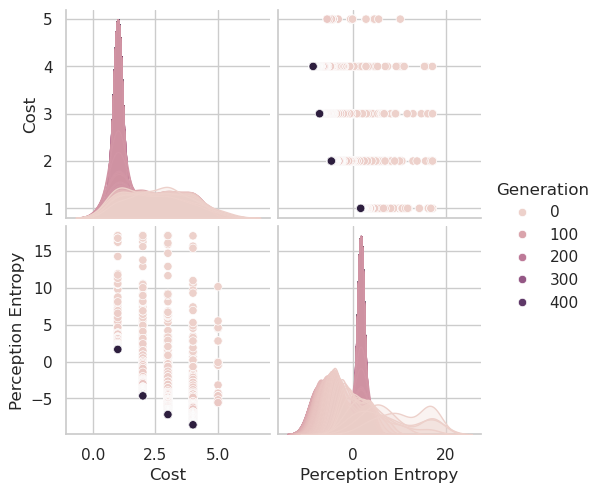

In [23]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)

pair_plot_df = df[["Generation", "Cost", "Perception Entropy"]]
sns.pairplot(pair_plot_df, hue="Generation", diag_kind="kde")


## Set up the problem from json

In [42]:
json_prolem_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/problem_Robot_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

prior_bot_from_problem = problem.prior_bot

## Plot any bot from the df above

In [43]:
from plotly.subplots import make_subplots

INDEX_TO_PLOT = 2

design_x_dict = df[df["id"] == INDEX_TO_PLOT].iloc[0].to_dict()
bot_x = problem.convert_1D_to_bot(design_x_dict)
design_x_fig = bot_x.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

design_0_dict = df[df["id"] == 0].iloc[0].to_dict()
bot_0 = problem.convert_1D_to_bot(design_0_dict)
design_0_fig = bot_0.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

combined_fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])
for trace in design_0_fig.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in design_x_fig.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(
    title_text=f"Design 0 (PE:{design_0_dict["Perception Entropy"]:.2f}) vs Design {INDEX_TO_PLOT} (PE:{design_x_dict["Perception Entropy"]:.2f})",
    showlegend=False,
    width=1200,
    height=600,
)

combined_fig.show()

In [44]:
sensor_0:Sensor3D_Instance = problem.prior_bot.sensors[0]

fig = sensor_0.plot_rays(*sensor_0.get_rays(verbose=True), show=False, ray_length=2)

for trace in design_0_fig.data:
    fig.add_trace(trace)

fig

Rays for None calculated in 0.001 sec.
  RAY ORIGINS max: 0.5, min: 0.0, mean: 0.1666666567325592
  RAY DIRECTIONS max: 1.0, min: -1.0, mean: 0.208052396774292
    H_ANGLES max: 1.5707963705062866, min: -1.5707963705062866, mean: -8.514949634275126e-09
    V_ANGLES max: 0.2617993950843811, min: -0.2617993950843811, mean: 0.0


In [82]:
ro, rd = torch.tensor([[0.0, 0.0, 0.5]]), torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['',''],
                                                voxel_centers=torch.tensor([[0.5, 0, 0.5],
                                                                            [1.0, 0, 0.5]]),
                                                voxel_sizes=torch.tensor([0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
sensor_0.plot_rays(ro, rd, show=False, fig=one_ray_fig, ray_length=1.25)


one_ray_fig

In [80]:
simple_perception_space.batch_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.00 seconds for 1 rays and 2 voxels.
  VOXEL HITS max: 0.0, min: 0.0, mean: 0.0


tensor([0., 0.], device='cuda:0')